# Carcass interpolation model

Seismic horizon is a change in rock properties across a boundary between two layers of rock, particularly seismic velocity and density. Such changes are visible in seismic images (even for an untrained eye), and could be automatically detected. 

A possible approach to the task of semi-automatic horizon detection is to track reflection by hand on a very sparse grid and use a neural network to interpolate it on the whole seismic (spatial) range. This notebook shows how to do it in details.

* [Dataset](dataset)
* [Model architecture](architecture)
* [Training](training)
* [Validation](validation)
* [Criticism](criticism)
* [Conclusion](conclusion)
* [Suggestions for improvements](suggestions)


In [1]:
# Necessary imports
import os
import sys
import warnings

import numpy as np
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

sys.path.append('../..')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, F, D, P, R, W
from seismiqb.batchflow.models.torch import EncoderDecoder, ResBlock

from seismiqb import SeismicCubeset, Horizon, HorizonMetrics
from seismiqb import plot_image, plot_loss

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# Global parameters
FREQUENCIES = [200, 200]         # carcass frequency at `hard` and `easy` locations
CROP_SHAPE = (1, 256, 256)       # shape of sampled 3D crops
ITERS = 100                      # number of train iterations
BATCH_SIZE = 64                  # number of crops inside one batch

<a id='dataset'></a>
# Dataset

We use only one cube and one horizon at a time. The next cell loads them into one entity `dataset`:

In [3]:
cube_path = '/data/seismic/CUBE_2/M_cube.hdf5'
horizon_path = '/data/seismic/CUBE_2/RAW/t0_B_anon'

dsi = FilesIndex(path=[cube_path], no_ext=True)
dataset = SeismicCubeset(dsi)

dataset.load_geometries()
dataset.create_labels({dataset.indices[0]: [horizon_path]})

geometry = dataset.geometries[0]
horizon = dataset.labels[0][0]

It is always nice to look at your data: the next cells show horizon depth map, as well as an example of seismic slice.

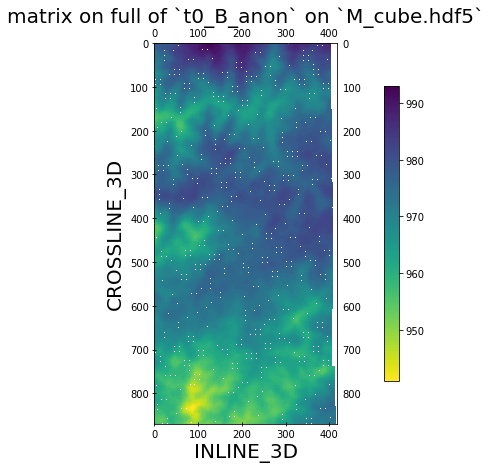

In [4]:
horizon.show()

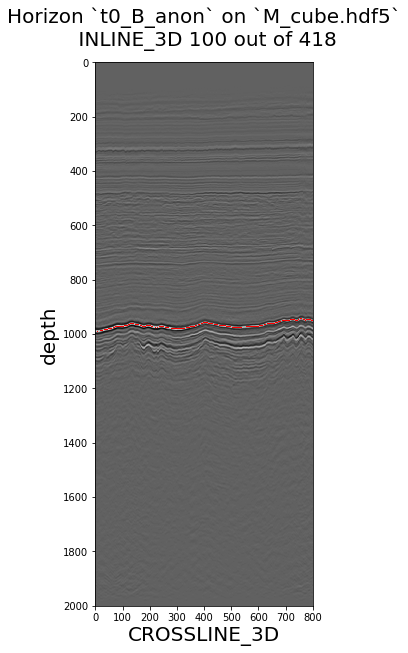

In [5]:
horizon.show_slide(100, axis=0, figsize=(10, 10))

It would be great to have a tool to assess quality of the horizon. What would be even better is to know exact locations, where the horizon is good (meaning that the reflection is tracked with the agreement with seismic and the phase of tracking is relatively not changing much), and where it can be further improved.

Furtunately, we provide such a tool! By the virtue of `HorizonMetrics`, we can compute maps that assess quality of each spatial point and provide key insight about labeled surface. To learn more about how they are created, check our [metrics notebook](./../../tutorials/04_Metrics.ipynb).

CPU times: user 31.7 s, sys: 15.9 s, total: 47.6 s
Wall time: 47.6 s


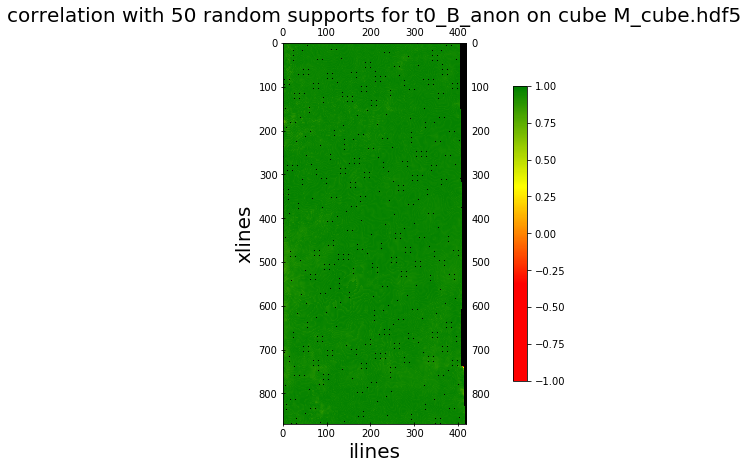

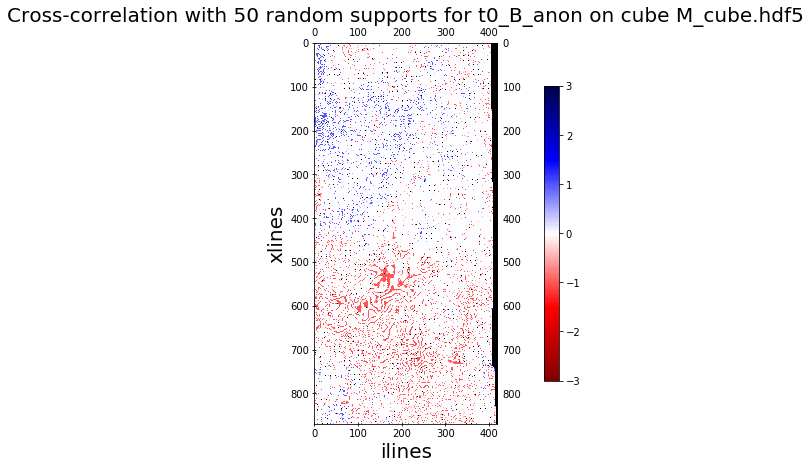

In [6]:
%%time
# Evaluate against seismic data
hm = HorizonMetrics(horizon)

corrs = hm.evaluate('support_corrs', agg='nanmean', supports=50, plot=True)
cross = hm.evaluate('support_crosscorrs', agg='median', supports=50, plot=True,
                    zmin=-3, zmax=3)

We want to train only on a sparse grid of labels and, obviously, there are a lot of ways of creating such a grid. Our approach is to locate  cube anomalies (you can learn more about that in [metrics notebook](./../../tutorials/04_Metrics.ipynb)), and then create grid corresponding to the local geological hardness of the data: the carcass is finer at the harder places, while there is no need for it in other, relatively easier places.

Grid covers 0.013 of the cube spatial ranges


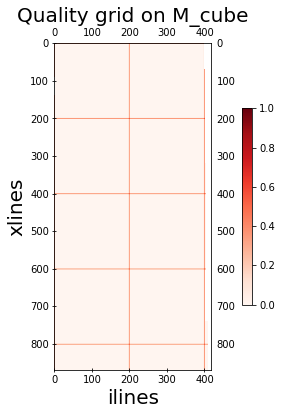

In [7]:
# Create carcass to train on
quality_grid = geometry.make_quality_grid(FREQUENCIES)
grid_coverage = (np.nansum(geometry.quality_grid) /
                 (np.prod(geometry.cube_shape[:2]) - np.nansum(geometry.zero_traces)))

print(f'Grid covers {grid_coverage:.2} of the cube spatial ranges')
plot_image(quality_grid, title=f'Quality grid on {geometry.short_name}',
           xlabel='ilines', ylabel='xlines',
           cmap='Reds', interpolation='bilinear', rgb=True, figsize=(8, 6))

As we can see, there are very few slices left! Note that some of them are `inline`-oriented, some of them are `xline`-oriented: our framework allows to dynamically sample slices in different directions.

As usual, we train the model on 3D crops of data cut from the cube. We need a mechanism of sampling such crops, and that is exactly what `Sampler` is doing. Output of the next cell shows actual sampled slices, that (potentially) can be used at training time. Color corresponds to frequency of the spatial point appearing in the batch.

***Note the `adaptive` slices: that is the parameter that tells our library to sample points only from the grid.***

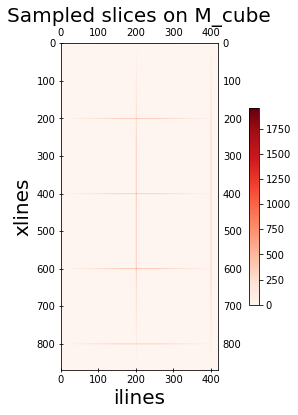

In [8]:
# Create sampler, according to carcass
dataset.create_sampler(quality_grid=True)
dataset.modify_sampler('train_sampler', finish=True)

_ = dataset.show_slices(src_sampler='train_sampler',
                        normalize=False, shape=CROP_SHAPE,
                        adaptive_slices=True,
                        cmap='Reds', interpolation='bilinear',
                        figsize=(8, 6))

As a sanity check, let's create test sampler, that is not tied to the grid in any way: we will use it later to check our model performance on the whole cube.

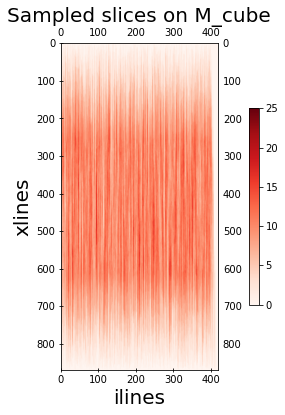

In [9]:
dataset.create_sampler(quality_grid=False)
dataset.modify_sampler('test_sampler', finish=True)

_ = dataset.show_slices(src_sampler='test_sampler',
                        normalize=False, shape=CROP_SHAPE,
                        adaptive_slices=False,
                        cmap='Reds', interpolation='bilinear',
                        figsize=(8, 6))

<a id='architecture'></a>
# Model architecture

We use convolutional neural network in `hourglass` manner, that consists of following parts:

- Initial processing via [`ResNet`](https://arxiv.org/abs/1512.03385) blocks
- Backbone to encode the image: it is very similar to `ResNet` and downsamples the input by a factor of 16
- Embedding layer
- Decoder, that takes output of the embedding and upsamples it to initial size, using pre-stored skip-connections to include informations from an earlier layers

We optimize Dice-coefficient with `Adam` algorithm. Due to enormous size of crops, we split every batch into pieces (called microbatches), accumulate gradients from each of them and, after the final piece is passed through, update neural network weights. Notably we use `relu6` activation function, as our researches show us that most of the activations are within its range, and all the outliers only hamper the model performance.

In [10]:
MODEL_CONFIG = {
    # Model layout
    'initial_block': {
        'base_block': ResBlock,
        'filters': 16,
        'kernel_size': 5,
        'downsample': False,
        'attention': 'scse'
    },

    'body/encoder': {
        'num_stages': 4,
        'order': 'sbd',
        'blocks': {
            'base': ResBlock,
            'n_reps': 1,
            'filters': [32, 64, 128, 256],
            'attention': 'scse',
        },
    },
    'body/embedding': {
        'base': ResBlock,
        'n_reps': 1,
        'filters': 256,
        'attention': 'scse',
    },
    'body/decoder': {
        'num_stages': 4,
        'upsample': {
            'layout': 'tna',
            'kernel_size': 2,
        },
        'blocks': {
            'base': ResBlock,
            'filters': [128, 64, 32, 16],
            'attention': 'scse',
        },
    },
    'head': {
        'base_block': ResBlock,
        'filters': [16, 8],
        'attention': 'scse'
    },
    'output': 'sigmoid',
    # Train configuration
    'loss': 'bdice',
    'optimizer': {'name': 'Adam', 'lr': 0.01,},
    'decay': {'name': 'exp', 'gamma': 0.1, 'frequency': 150},
    'microbatch': 4,
    'common/activation': 'relu6',
}

<a id='training'></a>
# Training

Pipeline of training consists of following steps:

- First of all, we create locations of crops to cut (`crop` action)
- Then we create masks, load actual seismic data
- As some of the crops are `iline`-oriented, and some of them are `xline`-oriented, we need to force equal shape on all of them. That is what `adaptive_reshape` for!
- We normalize seismic data by dividing by 99 quantile of the data in that cube: this way, most of the data is in $[-1, 1]$ range
- We apply loads of augmentations: after all, our training dataset consists of just a few seismic slices! We are enriching them by using flips, rotations, zoom, elastic transforms.

***Note that we use `transpose` before and after augmentations: turns out, that it is faster to make our crop look like an image and use highly optimized `OpenCV` routines, than to apply transformations along 'unadvantageous' axes.***

In [11]:
train_template = (
    Pipeline()
    # Initialize pipeline variables and model
    .init_variable('loss_history', [])
    .init_model('dynamic', EncoderDecoder, 'model', MODEL_CONFIG)

    # Load data/masks
    .crop(points=D('train_sampler')(BATCH_SIZE),
          shape=CROP_SHAPE, adaptive_slices=True)
    .create_masks(dst='masks', width=4)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images', 'masks'], shape=CROP_SHAPE)
    .scale(mode='q', src='images')

    # Augmentations
    .transpose(src=['images', 'masks'], order=(1, 2, 0))
    .additive_noise(scale=0.005, src='images', dst='images', p=0.3)
    .flip(axis=1, src=['images', 'masks'],
          seed=P(R('uniform', 0, 1)), p=0.3)
    .rotate(angle=P(R('uniform', -15, 15)),
            src=['images', 'masks'], p=0.3)
    .scale_2d(scale=P(R('uniform', 0.85, 1.15)),
              src=['images', 'masks'], p=0.3)
    .elastic_transform(alpha=P(R('uniform', 35, 45)),
                       sigma=P(R('uniform', 4, 4.5)),
                       src=['images', 'masks'], p=0.2)
    .transpose(src=['images', 'masks'], order=(2, 0, 1))

    # Training
    .train_model('model',
                 fetches='loss',
                 images=B('images'),
                 masks=B('masks'),
                 save_to=V('loss_history', mode='a'))
)

train_pipeline = train_template << dataset

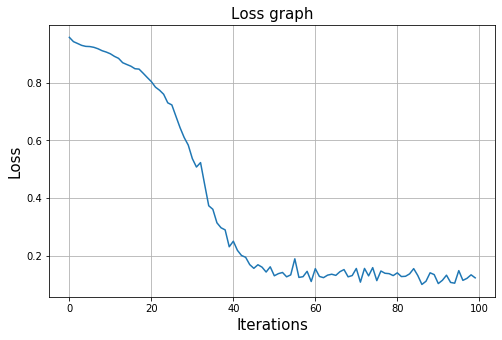

CPU times: user 1min 59s, sys: 21.1 s, total: 2min 20s
Wall time: 3min 37s


In [12]:
%%time
train_pipeline.run(D('size'), n_iters=ITERS,
                   bar={'bar': 'n', 'monitors': 'loss_history'})

plot_loss(train_pipeline.v('loss_history'))

We can see that loss platoed rather quickly. High fluctuations suggest that using larger batch size may be of help, as well as the more agressive learning rate scheduler.

<a id='validation'></a>
# Validation

Now we can use the model on previously unseen data. We use our `test_sampler`, that generates points from all around the cube and allows us to thoroughly examine model performance:

In [13]:
# Validation pipeline: no augmentations
val_template = (
    Pipeline()
    # Import model
    .import_model('model', train_pipeline)

    # Load data/masks
    .crop(points=D('test_sampler')(4), shape=CROP_SHAPE)
    .load_cubes(dst='images')
    .create_masks(dst='masks')
    .scale(mode='q', src='images')

    # Predict with model
    .predict_model('model',
                   B('images'),
                   fetches='predictions',
                   save_to=B('predictions'))
    .transpose(src=['images', 'masks', 'predictions'],
               order=(1, 2, 0))
)
val_pipeline = val_template << dataset

In [14]:
batch = val_pipeline.next_batch(D('size'))

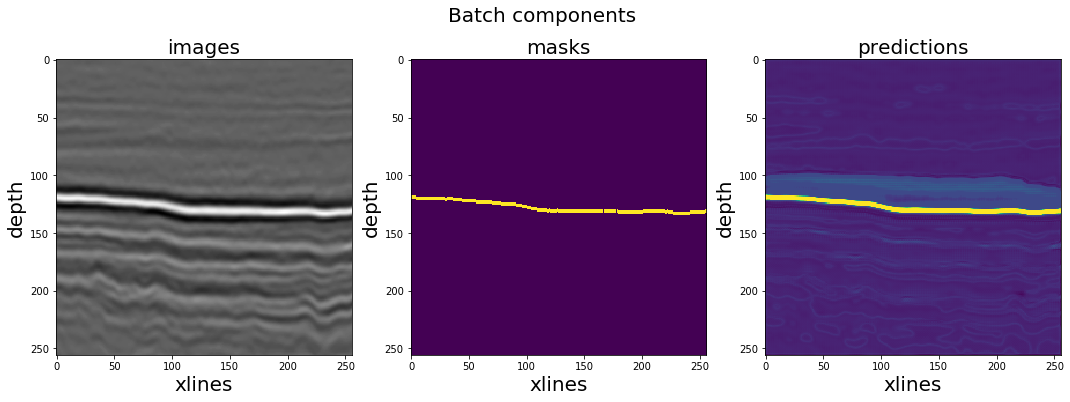

In [15]:
b_idx = 0
batch.plot_components('images', 'masks', 'predictions', mode='separate', idx=b_idx)

It is evident that model easily tracks the horizon.

Now we can save the trained model for later usage:

In [16]:
model_save_dir = '/data/seismic/SAVED/MODELS/demo_carcass'

train_pipeline.save_model_now('model', model_save_dir)

# Inference

Now is the perfect time to use our model to reconstruct the whole horizon: we can do so by:
- splitting the cube into chunks that cover the entire seismic range
- for each of them, make a prediction with the model
- aggregate predictions into one giant 3D array
- extract the horizon surface from it

Next cells do exactly that: `make_grid` creates grid of crop-sized chunks, `inference_pipeline` is used to make predictions, and `from_mask` method of `Horizon` allows us to locate the surface inside 3D array.

***Note that `from_mask` is more that capable of detecting and extracting multiple horizons from the volume. In the task of horizon interpolation we expect only one surface, so we take only the biggest of the produced horizons for later evaluation.***

In [17]:
inference_template = (
    Pipeline()
    # Initialize everything
    .init_variable('result_preds', [])
    .import_model('model', train_pipeline)

    # Load data
    .crop(points=D('grid_gen')(),
          shape=CROP_SHAPE)
    .load_cubes(dst='images')
    .adaptive_reshape(src='images', shape=CROP_SHAPE)
    .scale(mode='q', src='images')

    # Predict with model, then aggregate
    .predict_model('model',
                   B('images'),
                   fetches='predictions',
                   save_to=V('result_preds', mode='e'))
)

In [18]:
dataset.make_grid(dataset.indices[0], CROP_SHAPE,
                  [0, 417], [0, 868], [800, 1000],
                  overlap=(1, 96, 96),
                  batch_size=BATCH_SIZE*2)

inference_pipeline = inference_template << dataset
inference_pipeline.run(D('size'), n_iters=dataset.grid_iters, bar='n')

assembled_pred = dataset.assemble_crops(inference_pipeline.v('result_preds'), order=(0, 1, 2))

In [19]:
horizons = Horizon.from_mask(assembled_pred, dataset.grid_info,
                             minsize=50, threshold=0.5)

predicted_horizon = horizons[-1] # the biggest one

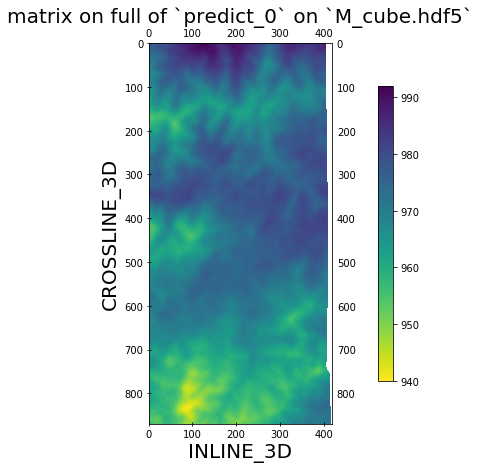

In [20]:
predicted_horizon.show()

As we can see, there are some rough pathes at the edges, but the overwhelming majority of points is labeled.

Now we apply the same evaluating procedure, as was applied to the target horizon:

CPU times: user 30.7 s, sys: 15.1 s, total: 45.7 s
Wall time: 45.7 s


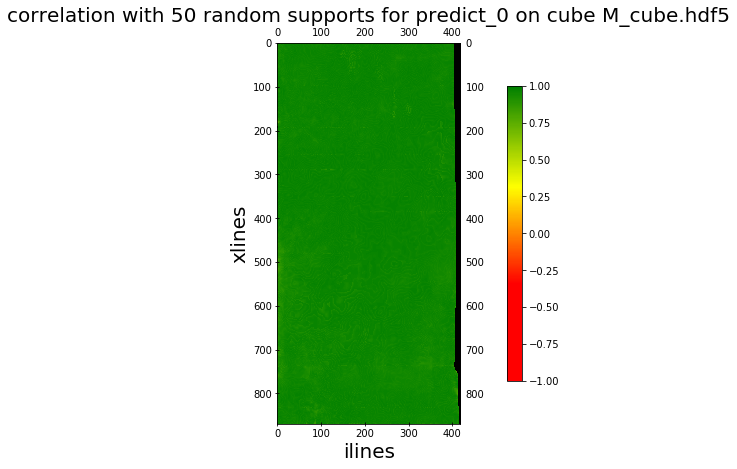

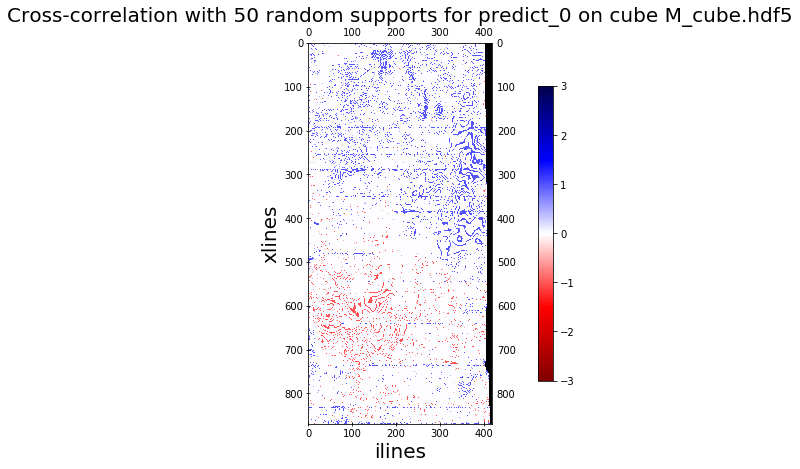

In [21]:
%%time
# Evaluate against seismic data
hm = HorizonMetrics(predicted_horizon)

corrs = hm.evaluate('support_corrs', agg='nanmean', supports=50, plot=True)
cross = hm.evaluate('support_crosscorrs', agg='median', supports=50, plot=True,
                    zmin=-3, zmax=3)

As we can see, the quality of tracking is even better, than it was in the original horizon! That is because the model learned on very small amount of slices, where tracked phase was relatively unchanged, and picked the same phase on the rest of the cube points.

Finally, we compare prediction and target horizon head-to-head:


Comparing horizons:       predict_0
                          t0_B_anon
—————————————————————————————————————————————

Rate in 5ms:                              1.0
Mean/std of errors:        -0.8296 /   0.3969
Mean/std of abs errors:     0.8297 /   0.3968
Max error/abd error:             1 /        2
—————————————————————————————————————————————

Lengths of horizons:                   352199
                                       348969
—————————————————————————————————————————————
Average heights of horizons:         969.7142808469076
                                     970.5310328424588
—————————————————————————————————————————————
Coverage of horizons:                  0.9985
                                       0.9893
—————————————————————————————————————————————
Solidity of horizons:                     1.0
                                       0.9926
—————————————————————————————————————————————
Number of holes in horizons:                0
                                 

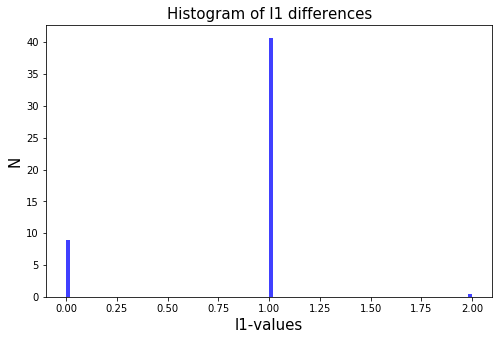

CPU times: user 460 ms, sys: 14.5 ms, total: 475 ms
Wall time: 463 ms


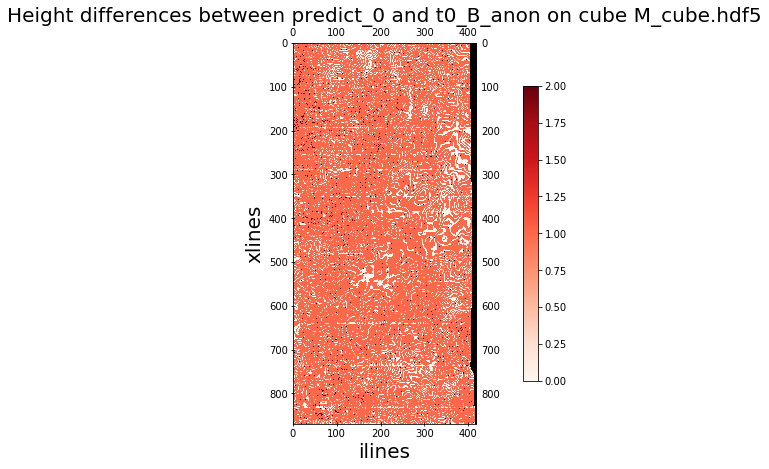

In [22]:
%%time
# Evaluate against target horizon
dataset.compare_to_labels(predicted_horizon)

<a id='criticism'></a>
# Criticism

It is unclear whether the model is too big for the task at hand: there is a chance, that the same results can be obtained with way smaller neural network.

<a id='conclusion'></a>
# Conclusion

As of now, the model is more than capable of extending a sparse carcass to a whole spatial range of the cube.

<a id='suggestions'></a>
# Suggestion for improvements

A detailed research on hyperparameters should be performed: model architecture can be chosen better, as well as `crop_shape` that has a huge influence on the quality of predictions.